# Import Packages

In [1]:
import pyomo.environ as pe
import matplotlib.pyplot as plt
import networkx as nx
from networkx.drawing.nx_agraph import write_dot, graphviz_layout
model = pe.ConcreteModel(name='815Project')

# Import Data

In [2]:
data = pe.DataPortal()
data.load(filename="./simpleexample.dat")

# Declare Sets

In [3]:
# Total nodes
model.N = pe.Set(initialize=data['N'])
# total vehicles
model.K = pe.Set(initialize=data['K'])
# total requests
model.R = pe.Set(initialize=data['R'])
# transshipment node
model.T = pe.Set(within=model.N,initialize=data['T'])

# Initialize Parameters

In [4]:
# load carrying capacity
model.u = pe.Param(model.K,within=pe.NonNegativeReals,initialize=data['u'])
# initial depot
model.o = pe.Param(model.K,within=model.N,initialize=data['o'])
# final depot
model.o_ = pe.Param(model.K,within=model.N,initialize=data['o_'])
# request quantity
model.q = pe.Param(model.R,within=pe.NonNegativeReals,initialize=data['q'])
# request pick up
model.p = pe.Param(model.R,within=model.N,initialize=data['p'])
# request drop pff
model.d = pe.Param(model.R,within=model.N,initialize=data['d'])
# transport cost
model.c = pe.Param(model.N,model.N,model.K,within=pe.NonNegativeReals,initialize=0,mutable=True)

In [5]:
# slight adjustments to cost
data = pe.DataPortal()
data.load(filename="./simpleexample.dat",model=model)
for index,value in data['c'].items():
    model.c[index] = value
# total arcs
def arcs_rule(model,i,j):
    return model.c[i,j,1].value > 0
model.A = pe.Set(initialize=model.N*model.N, filter = arcs_rule)

# Declare Variables

In [6]:
# if a car K travels in arc A
model.x = pe.Var(model.A,model.K,within=pe.Binary)
# if a car K travels in arc A carries order R
model.y = pe.Var(model.A,model.K,model.R,within=pe.Binary)

# Write Constraints

(1) enforce that each vehicle may initiate at most one route from its origin depot; constraints

In [7]:
def one_car_start_rule(model,i,k):
    if i == model.o[k]:
        return sum(model.x[i,j,k] for j in model.N if (i,j) in model.A) <= 1
    else:
        return pe.Constraint.Skip
model.one_car_start_con = pe.Constraint(model.N,model.K,rule=one_car_start_rule)

(2) enforce that the same vehicle must end the route at its ﬁnal depot.

In [8]:
def end_at_final_rule(model,i,l,k):
    if i == model.o[k] and l == model.o_[k]:
        return sum(model.x[i,j,k] for j in model.N if (i,j) in model.A) \
                == sum(model.x[j,l,k] for j in model.N if (j,l) in model.A)
    else:
        return pe.Constraint.Skip
model.end_at_final_con = pe.Constraint(model.N,model.N,model.K,rule=end_at_final_rule)

(3) maintain ﬂow conservation of the vehicles through the nodes in the network.

In [9]:
def flow_conservation_rule(model,i,k):
    if i != model.o[k] and i != model.o_[k]:
        return sum(model.x[i,j,k] for j in model.N if (i,j) in model.A) \
                == sum(model.x[j,i,k] for j in model.N if (j,i) in model.A)
    else:
        return pe.Constraint.Skip
model.flow_conservation_con = pe.Constraint(model.N,model.K,rule=flow_conservation_rule)

(4) & (5) enforce all pickups and deliveries of the customer requests.

In [10]:
def pickup_request_rule(model,i,r):
    if i == model.p[r]:
        return sum(model.y[i,j,k,r] for k in model.K for j in model.N if (i,j) in model.A) == 1
    else:
        return pe.Constraint.Skip
model.pickup_request_con = pe.Constraint(model.N,model.R,rule=pickup_request_rule)

In [11]:
def deliver_request_rule(model,i,r):
    if i == model.d[r]:
        return sum(model.y[j,i,k,r] for k in model.K for j in model.N if (j,i) in model.A) == 1
    else:
        return pe.Constraint.Skip
model.deliver_request_con = pe.Constraint(model.N,model.R,rule=deliver_request_rule)

(6) maintain the request ﬂow conservation at the transshipment nodes allowing requests to switch from one vehicle to another while constraints

**Special Note: Deviation (correction) from paper formulation**

In [12]:
def trans_conservation_rule(model,i,r):
    
    how_many_package_to_be_dropped = 1 if i == model.d[r] else 0
    how_many_package_to_be_picked = 1 if i == model.p[r] else 0
    
    return sum(model.y[i,j,k,r] for k in model.K for j in model.N if (i,j) in model.A) \
            + how_many_package_to_be_dropped \
            == sum(model.y[j,i,k,r] for k in model.K for j in model.N if (j,i) in model.A) \
            + how_many_package_to_be_picked
model.trans_conservation_con = pe.Constraint(model.T,model.R,rule=trans_conservation_rule)

(7) maintain the request ﬂow conservation at the non-transshipment nodes requiring that any vehicle bringing a request must also leave carrying the same request.

In [13]:
def request_conservation_rule(model,i,k,r):
    if i not in model.T and i != model.p[r] and i != model.d[r]:
        return sum(model.y[i,j,k,r] for j in model.N if (i,j) in model.A) \
                == sum(model.y[j,i,k,r] for j in model.N if (j,i) in model.A)
    else:
        return pe.Constraint.Skip
model.request_conservation_con = pe.Constraint(model.N,model.K,model.R,rule=request_conservation_rule)

(8) enforce a vehicle ﬂow on an arc if there is some request ﬂow in the same vehicle on the same arc.

In [14]:
def request_needs_car_rule(model,i,j,k,r):
    return model.y[i,j,k,r] <= model.x[i,j,k]
model.request_needs_car_con = pe.Constraint(model.A,model.K,model.R,rule=request_needs_car_rule)

(9) ensure capacity of each vehicle on each arc of the network

In [15]:
def capacity_rule(model,i,j,k):
    return sum(model.q[r]*model.y[i,j,k,r] for r in model.R) <= model.u[k] * model.x[i,j,k]
model.capacity_con = pe.Constraint(model.A,model.K,rule=capacity_rule)

# Declare Objective

In [16]:
model.obj = pe.Objective(expr=sum(model.c[i,j,k]*model.x[i,j,k] for i,j in model.A for k in model.K))

In [17]:
opt = pe.SolverFactory('gurobi')

In [18]:
opt.solve(model,options={'mipgap':0},tee=True);

Academic license - for non-commercial use only
Read LP format model from file /Users/naienh/Desktop/815/tmpo8fu6ole.pyomo.lp
Reading time = 0.00 seconds
x161: 230 rows, 161 columns, 729 nonzeros
Changed value of parameter mipgap to 0.0
   Prev: 0.0001  Min: 0.0  Max: 1e+100  Default: 0.0001
Optimize a model with 230 rows, 161 columns and 729 nonzeros
Variable types: 1 continuous, 160 integer (160 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+00]
  Objective range  [1e+00, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 25.0000000
Presolve removed 210 rows and 137 columns
Presolve time: 0.00s
Presolved: 20 rows, 24 columns, 80 nonzeros
Found heuristic solution: objective 22.0000000
Variable types: 0 continuous, 24 integer (24 binary)

Root relaxation: objective 1.500000e+01, 14 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf 

In [19]:
collector_car = []
for i in model.x:
    if model.x[i] == 1:
        collector_car.append(i[:-1])
collector_car = sorted(collector_car,key=lambda x: x[0])

In [20]:
collector_package = []
for i in model.y:
    if model.y[i] == 1:
        collector_package.append(i[:-2])
collector_package = sorted(collector_package,key=lambda x: x[0])

# Let's plot the graph

In [21]:
G = nx.MultiDiGraph()

In [22]:
G.add_nodes_from(model.N)
G.add_edges_from(collector_car);
G.add_edges_from(collector_package);

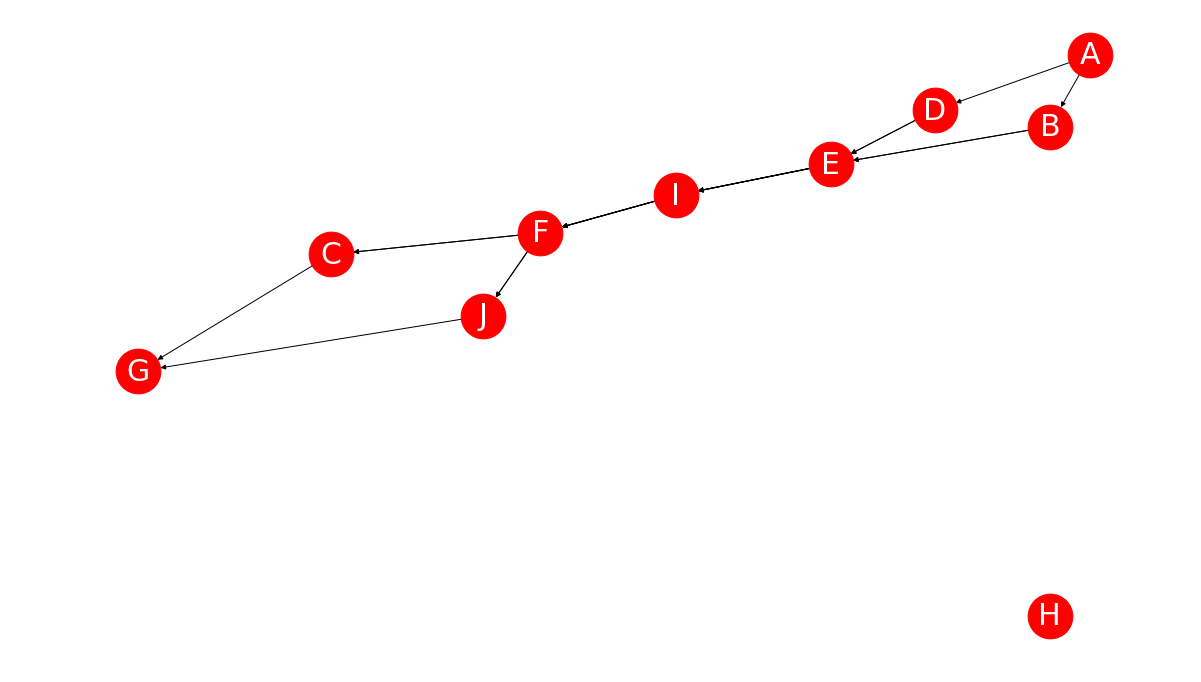

In [23]:
plt.figure(figsize=(16,9))
nx.draw(G,pos=nx.spring_layout(G), with_labels=True, font_size=30,node_size=2000,font_color='w')
plt.show()